# Build a WFlow model anywhere

In this notebook we will setup a WFlow model coupled to the FloodAdapt backend

## **Step 0:** Import dependencies

In [1]:
from pathlib import Path
import hydromt
import geopandas as gpd
from hydromt.log import setuplog
from hydromt.config import configread
from hydromt_wflow import WflowModel

from DT_flood.utils.plot_utils import plot_wflow_model

In [2]:
model_name = 'Humber'
model_path = Path("/home/wotromp/InterTwin/FloodAdapt_database") / model_name
# model_path = Path('c:/Repositories/DT-flood/FloodAdapt_database') / model_name
# model_path = Path("../FloodAdapt_database") / model_name

wf_root = model_path / Path('static/templates/wflow')

wf_logger_name = 'WFlow_Logger'

region_fn = model_path / 'HumberDelta_large.geojson'

In [3]:
# Use this for own data_catalog file
data_catalog_fn = Path("/home/wotromp/InterTwin/Data/Humber/data_catalog.yml")
# data_catalog_fn = Path('c:/Users/tromp_wm/OneDrive - Stichting Deltares/Documents/InterTwin Project/Data/DTFlood_test_catalog.yml')

# data_dict = {
#     'topo': 'copdem30',
#     'bathy': 'gebco',
#     'waterlevels': 'gtsm_hourly',
#     'meteo': 'era5_hourly',
#     'infiltration': 'gcn250',
#     'lulc': 'esa_worldcover',
#     'basins': 'BasinAtlas',
# }

In [4]:
wf_logger = setuplog(wf_logger_name,log_level=10)

# data_catalog = hydromt.DataCatalog(data_libs=data_catalog_fn,logger=wf_logger)

# wf = WflowModel(data_libs=[data_catalog_fn, 'deltares_data=v2023.2'], root=wf_root, mode='w+')
wf = WflowModel(data_libs=[data_catalog_fn], root=wf_root, mode='w+')

2024-09-13 14:37:08,108 - WFlow_Logger - log - INFO - HydroMT version: 0.9.4


In [5]:
ini_fn = model_path / "wflow_build.ini"
opt = configread(ini_fn)

region = gpd.read_file(region_fn)

In [6]:
wf.build(region={'basin': region, 'outlets': True}, opt=opt)

No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata
No numerical nodata value found, skipping set_nodata


In [7]:
gauges_fn = wf_root.parent/"overland"/"gis"/"src.geojson"
wf.setup_gauges(
    gauges_fn=gauges_fn,
    index_col='index',
    snap_to_river=True,
    snap_uparea=True,
    derive_subcatch=False,
)

In [8]:
wf.geoms["gauges_src"]

,geometry,uparea
index,,
1,POINT (-0.78667 53.41583),9470.755859
2,POINT (-1.12000 53.84917),3598.632812
3,POINT (-1.36167 53.74083),1850.429321
4,POINT (-0.94500 53.89083),1547.833862
5,POINT (-1.12000 53.54083),1252.166992
6,POINT (-1.14500 53.84083),989.947021
7,POINT (-1.37000 53.73250),956.146118
8,POINT (-1.37000 53.74083),893.932739
9,POINT (-1.00333 53.40750),561.345154


In [9]:
setting_toml = {
    "netcdf.path": f"output_scalar.nc",
    "netcdf.variable": [
        {
            "name": "Q_src",
            "map": "gauges_src",
            "parameter": "lateral.river.q_av",
        }
    ],
}
for option in setting_toml:
    wf.set_config(option, setting_toml[option])
wf.write_config()

In [11]:
wf.write()

In [12]:
wf_read = WflowModel(root=wf_root, mode="r")

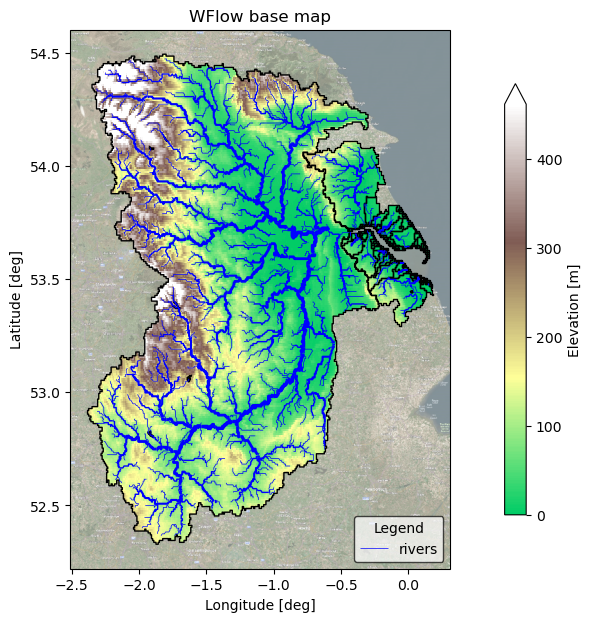

In [13]:
plot_wflow_model(wf_read)